<p align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens"/> </p>

<br>

---

<h3 align="center" > 
  Bachelor Thesis
</h3>

<h1 align="center" > 
  Entity Resolution in Dissimilarity Spaces <br>
  Implementation notebook
</h1>

---

<h3 align="center"> 
 <b>Konstantinos Nikoletos</b>
</h3>

<h4 align="center"> 
 <b>Supervisors:<br> Dr. Alex Delis</b>,  Professor NKUA <br> <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University

</h4>
<br>
<h4 align="center"> 
Athens
</h4>
<h4 align="center"> 
January 2021 - Ongoing
</h4>


---

# __Implementation__

## __0.0 Install components__

In [ ]:
!pip install editdistance

In [ ]:
!pip install pandas
import pandas as pd
print(pd.__version__)

In [ ]:
!pip install pandas_read_xml

In [ ]:
!pip install requests

## __0.1 Import libraries__

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk import jaccard_distance
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score

plt.style.use('seaborn-whitegrid') # plot style

## __Final model__









In [51]:
class RankedWTAHash:

  def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,jaccard_withchars =True,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', ngramms=3, similarityThreshold=None, maxOnly=None ):
    '''
      Constructor
    '''
    self.max_numberOf_clusters = max_numberOf_clusters
    self.pairDictionary = dict()
    self.max_editDistance = max_editDistance
    self.windowSize = windowSize
    self.S_set = None 
    self.S_index = None 
    self.similarityThreshold = similarityThreshold
    self.maxOnly = maxOnly
    self.metric = metric
    self.min_numOfNodes = min_numOfNodes
    self.similarityVectors = similarityVectors
    self.number_of_permutations = number_of_permutations
    self.distanceMetric = distanceMetric
    self.distanceMetricEmbedding = distanceMetricEmbedding
    self.ngramms = ngramms
    self.jaccard_withchars =  jaccard_withchars
  
  def fit(self, X):
    """
      Fit the classifier from the training dataset.
      Parameters
      ----------
      X : Training data.
      Returns
      -------
      self : The fitted classifier.
    """
    print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

    if isinstance(X, list):
      input_strings = X
    else:
      input_strings = list(X)

    # print(input_strings)
    self.initialS_set = np.array(input_strings,dtype=object)
    self.S_set = np.array(input_strings,dtype=object)
    if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(data[i]), n=self.ngramms))
    elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(data[i], n=self.ngramms))
    # print(self.S_set)

    self.S_index = np.arange(0,len(input_strings),1)

    # print("\n\nString positions are:")
    # print(self.S_index)
    # print("\n")

    print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
    print("\n-> Finding prototypes and representatives of each cluster:")
    prototypes_time = time.time()
    self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
    print("\n- Prototypes selected")
    self.embeddingDim = self.prototypeArray.size
    print(self.prototypeArray)
    for pr in self.prototypeArray:
        print(pr," -> ",self.initialS_set[pr])
    print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
    prototypes_time = time.time() - prototypes_time
    print("\n# Finished in %.6s secs" % (prototypes_time))
    print("\n")

    print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
    print("\n-> Creating Embeddings:")
    embeddings_time = time.time()
    self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
    print("- Embeddings created")
    print(self.Embeddings)
    embeddings_time = time.time() - embeddings_time
    print("\n# Finished in %.6s secs" % (embeddings_time))
    print("\n")


    print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
    print("\n-> Creating WTA Buckets:")
    wta_time = time.time()
    self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize,self.embeddingDim, self.number_of_permutations)
    print("- WTA buckets: ")
    for key in self.buckets.keys():
      print(key," -> ",self.buckets[key])
    print("\n- WTA number of buckets: ", len(self.buckets.keys()))
    print("\n- WTA RankedVectors after permutation:")
    print(self.rankedVectors)
    wta_time = time.time() - wta_time
    print("\n# Finished in %.6s secs" % (wta_time))
    print("\n")

    print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
    print("\n-> Similarity checking:")
    similarity_time = time.time()

    if self.similarityVectors == 'ranked':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
    elif self.similarityVectors == 'initial':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)      
    else:
      warnings.warn("similarityVectors: Available options are ranked,initial")
#     print("- Similarity matrix (all values compared):")
#     print(self.similarityProb_matrix)
    print("- Similarity mapping in a matrix")
    print(self.mapping_matrix)
    similarity_time = time.time() - similarity_time
    print("\n# Finished in %.6s secs" % (similarity_time))
    print("\n#####################################################################\n#                    .~ End of training ~.                          #\n#####################################################################\n")

    return self

  def EditDistance(self, str1,str2,verbose=False):
      if verbose:
        if str1 == None:
            print("1")
        elif str2 == None:
            print("2")
        print("-> "+str(str1))
        print("--> "+str(str2))
        print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))
      
      
      # NOTE: Duplicates inside the dictionary     

      if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
        return self.pairDictionary[(str1,str2)]
      else:
        # if verbose:
        # print("++++++++++")
        # print(str1,str2)
        # print(self.S_set[str1],self.S_set[str2])
        # print("++++++++++")
        if self.distanceMetric == 'edit':
            distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
        elif self.distanceMetric == 'jaccard':
            distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
        else:
            warnings.warn("Available metrics for space creation: edit, jaccard ")
        self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
        return distance

  #####################################################################
  # 1. Prototype selection algorithm                                  #
  #####################################################################

  '''
  Clustering_Prototypes(S,k,d,r,C) 
  The String Clustering and Prototype Selection Algorithm
  is the main clustering method, that takes as input the intial strings S, 
  the max number of clusters to be generated in k,
  the maximum allowable distance of a string to join a cluster in var d
  and returns the prototype for each cluster in array Prototype
  '''
  def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):
      
      # ----------------- Initialization phase ----------------- #
      i = 0
      j = 0
      C = np.empty([S.size], dtype=int)
      r = np.empty([2,k],dtype=object)

      Clusters = [ [] for l in range(0,k)]

      for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
          while j < k :       # iteration through clusters, for all clusters
              if r[0][j] == None:      # case empty first representative for cluster j
                  r[0][j] = S[i]   # init cluster representative with string i
                  C[i] = j         # store in C that i-string belongs to cluster j
                  Clusters[j].append(S[i])
                  break
              elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative 
                  r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string 
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              else:
                  j += 1
          i += 1

      # ----------------- Prototype selection phase ----------------- #
          
      Projections = np.empty([k],dtype=object)
      Prototypes = np.empty([k],dtype=int)
      sortedProjections = np.empty([k],dtype=object)

      Projections = []
      Prototypes = []
      sortedProjections = []

      if verbose:
          print("- - - - - - - - -")
          print("Cluster array:")
          print(C)
          print("- - - - - - - - -")
          print("Represantatives array:")
          print(r)
          print("- - - - - - - - -")  
          print("Clusters:")
          print(Clusters)
          print("- - - - - - - - -")  

      new_numofClusters = k

      # print("\n\n\n****** Prototype selection phase *********") 
      prototype_index = 0
      for j in range(0,k,1):
          
          # IF small cluster
          # print("Len ",len(Clusters[j]))
          if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
            new_numofClusters-=1
            continue

          Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))         
          # print(Projections[prototype_index])
          sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
          
          
          Prototypes.append(self.Median(sortedProjections[prototype_index]))
          # print(Prototypes[prototype_index])

          prototype_index += 1

      # print("\n****** END *********\n")

      return np.array(Prototypes),new_numofClusters


  def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):
      # print("here")
      # print(clusterSet)
      # print(right_rep, left_rep)

      distances_vector = dict()

      if len(clusterSet) > 2:
        rep_distance     = self.EditDistance(right_rep,left_rep)
                 
        for str_inCluster in range(0,len(clusterSet)): 
          if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
            # print(clusterSet[str_inCluster],right_rep,left_rep)
            right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
            left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])
            
            if rep_distance == 0: 
              distances_vector[clusterSet[str_inCluster]] = 0
            else:
              distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
              distances_vector[clusterSet[str_inCluster]] = distance
      
      else:
#         print("set: ",clusterSet)
#         print("left: ",left_rep)
#         print("right: ",right_rep)
        if left_rep != None and right_rep == None:
          distances_vector[left_rep] = left_rep
          # print("l")
        elif right_rep != None and left_rep == None:
          distances_vector[right_rep] = right_rep
          # print("r")
        elif left_rep == None and right_rep == None:
          return None
        elif left_rep != None and right_rep != None:
          distances_vector[right_rep] = right_rep
          distances_vector[left_rep]  = left_rep
      # print(distances_vector)
      return distances_vector

  def Median(self, distances):    
      '''
      Returns the median value of a vector
      '''
      keys = list(distances.keys())
      if keys == 1:
        return keys[0]

      # print(distances)
      keys = list(distances.keys())
      # print(keys)
      median_position = int(len(keys)/2)
      # print(median_position)
      median_value = keys[median_position]

      return median_value
  

  
  #####################################################################
  #       2. Embeddings based on the Vantage objects                  #
  #####################################################################

  '''
  CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
  '''
  def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):
      
      # ------- Distance computing ------- #     
      vectors = []
      for s in tqdm(range(0,S.size)):
          string_embedding = []
          for p in range(0,VantageObjects.size): 
              if VantageObjects[p] != None:
#                   print("-",VantageObjects[p])
                  string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))
              
          # --- Ranking representation ---- #
          ranked_string_embedding = stats.rankdata(string_embedding, method='dense')
          
          # ------- Vectors dataset ------- #
          vectors.append(ranked_string_embedding)
      
      return np.array(vectors)
      

  '''
  DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
  '''
  def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):
      
      if distanceMetricEmbedding == 'l_inf':
          max_distance = None

          for pp in range(0,VantageObjects.size):
              if VantageObjects[pp] != None:
                  string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                  VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                  abs_diff = abs(string_distance-VO_distance)

                  # --- Max distance diff --- #        
                  if max_distance == None:
                      max_distance = abs_diff
                  elif abs_diff > max_distance:
                      max_distance = abs_diff
          return max_distance
    
      elif distanceMetricEmbedding == 'edit':
          return self.EditDistance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'jaccard':
          return jaccard_distance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'euclidean':
          return euclidean(S[s],VantageObjects[p])
      else:
          warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")
        

  def dropNone(array):
      array = list(filter(None, list(array)))
      return np.array(array)

  def topKPrototypes():
      return

  #####################################################################
  #                 3. Similarity checking                            # 
  #####################################################################

  def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):
    
#     print(buckets)
#     print(vectors)
    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]
    mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
    self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
    mapping = {}

    # Loop for every bucket
    for bucketid in tqdm(buckets.keys()):
      bucket_vectors = buckets[bucketid]
      numOfVectors = len(bucket_vectors)
      
      print(bucket_vectors)
      # For every vector inside the bucket
      for v_index in range(0,numOfVectors,1):
        v_vector_id = bucket_vectors[v_index]
        # Loop to all the other
        for i_index in range(v_index+1,numOfVectors,1):
          i_vector_id = bucket_vectors[i_index]
#           print('v_vector_id: ',v_vector_id,'i_vector_id: ',i_vector_id)
#           print(vectors[v_vector_id], " | ",vectors[i_vector_id])

          if vectorDim == 1:
            warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
            metric = 'kendal'

          if metric == None or metric == 'kendal':  # Simple Kendal tau metric
            similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'customKendal':  # Custom Kendal tau
            numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
            similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
          elif metric == 'jaccard':
            similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
          elif metric == 'cosine':
            similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
          elif metric == 'pearson':
            similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearman':
            similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearmanf':
            similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'hamming':
            similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
          elif metric == 'kruskal':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
              _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'ndcg_score':
            similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'mannwhitneyu':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
               _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
          else:
            warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")
          
          print("--",WTA_similarity(vectors[v_vector_id], vectors[i_vector_id]))
          self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob
#           print("pr: ",self.similarityProb_matrix[v_vector_id][i_vector_id],similarity_prob)
          # if v_vector_id == 0:
          #   print(v_vector_id, i_vector_id," : ",similarity_prob )        
          if similarity_prob > threshold:
            if v_vector_id not in mapping.keys():
              mapping[v_vector_id] = []
            mapping[v_vector_id].append(i_vector_id)  # insert into mapping
            mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
            mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix

    
    return mapping, np.triu(mapping_matrix)

  #####################################################################
  #                        4. WTA Hashing                             # 
  #####################################################################

  def WTA(self,vectors,K,inputDim, number_of_permutations):
    '''
      Winner Take All hash - Yagnik
      .............................

      K: window size
    '''
    newVectors = []
    buckets = dict()

    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]

    if vectorDim < K:
      K = vectorDim
      warnings.warn("Window size greater than vector dimension")
      
    C = np.zeros([numOfVectors,number_of_permutations], dtype=int)
    
#     X_new = np.array(vectors)
    
    permutation_dimension = inputDim
    for permutation_index in range(0,number_of_permutations,1):
        theta = np.random.permutation(permutation_dimension)
        i=0;j=0;
#         print(newVectors)
        for v_index in range(0,numOfVectors,1):
#           print(v_index)
          
          if permutation_index == 0:
#             print("Before: ",vectors[v_index])
            X_new = self.permuted(vectors[v_index],theta)
            newVectors.append(X_new)
          else:
#             print("Before: ",newVectors[v_index])
#             print(theta[:K])
            X_new = self.permuted(newVectors[v_index],theta)
            newVectors[v_index] = X_new
          
              
#           X_new = X_new[:K]
#           print("After: ",X_new)
#           print("X_new: ",X_new)
          C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
#           print("- ",index_max)
#           c_i = index_max

#           for j in range(0,K,1):
#             if X_new[j] > X_new[c_i]:
#               c_i = j

#           print("-> ",c_i)
#           C[i][permutation_index] = c_i
#           print(C)
          
          i+=1
        permutation_dimension = K

    for c,i in zip(C,range(0,numOfVectors,1)):
        buckets = self.bucketInsert(buckets,str(c),i)
#     print(C)
#     print(buckets)
    return C,buckets,np.array(newVectors,dtype=np.intp)

  def permuted(self,vector,permutation):
    permuted_vector = [vector[x] for x in permutation]
    return permuted_vector 

  def bucketInsert(self,buckets,bucket_id,item):
    if bucket_id not in buckets.keys():
      buckets[bucket_id] = []
    buckets[bucket_id].append(item)

    return buckets


### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [3]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=False ):

  print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
  true_matrix = sparse.triu(true_matrix)
  # print(true_matrix)
  predicted_matrix =  sparse.triu(predicted_matrix)
  # print(predicted_matrix)

  acc = 100*accuracy_score(true_matrix, predicted_matrix)
  f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
  recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
  precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

  print("Accuracy:  %3.2f %%" % (acc))
  print("F1-Score:  %3.2f %%" % (f1))
  print("Recall:    %3.2f %%" % (recall))
  print("Precision: %3.2f %%" % (precision))

  # results_dataframe = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
  # results_dataframe.loc[len(results_dataframe)+1] = [acc,precision,recall,f1]

  if with_classification_report:
    print(classification_report(true_matrix, predicted_matrix))

  print('\n\n')
  return acc,f1,precision,recall


### GridSearch function

In [4]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'Accuracy','Precision','Recall','F1','Time'])

    for n1 in tqdm(max_numberOf_clusters):
        for n2 in tqdm(max_editDistance):
            for n3 in tqdm(similarityThreshold):
                for n4 in tqdm(windowSize):
                    for n5 in tqdm(metric):
                        for n6 in tqdm(similarityVectors):
                            for n7 in tqdm(distanceMetricEmbedding):
                                for n8 in tqdm(distanceMetric):
                                    for n9 in tqdm(number_of_permutations):
                                        print("-------------------------")
                                        print('max_numberOf_clusters: ',n1)
                                        print('max_editDistancez: ',n2)
                                        print('similarityThreshold: ',n3)
                                        print('windowSize: ',n4)
                                        print('metric: ',n5)
                                        print('similarityVectors: ',n6)
                                        print('distanceMetricEmbedding: ',n7)
                                        print('distanceMetric: ',n8)
                                        print('number_of_permutations: ',n9)
                                        print("-------------------------")
                                        start = time.time()
                                        model = RankedWTAHash(
                                          max_numberOf_clusters= n1,
                                          max_editDistance= n2,
                                          windowSize= n4,
                                          similarityThreshold= n3,
                                          maxOnly= False,
                                          metric=n5,
                                          similarityVectors=n6
                                        )
                                        model = model.fit(data)
                                        exec_time = time.time() - start
                                        acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                                        results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,acc,precision,recall,f1,exec_time]

    return results_dataframe

In [54]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    return sdist/normalizer

def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0
            


# __Evaluation__

## __CoRA__ - New

### Load from Drive

In [6]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

### Jupyter load

In [7]:
import os
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")

In [8]:
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
xml_dataframe = cora
xml_dataframe['@id'] = pd.to_numeric(xml_dataframe['@id']).subtract(1)
xml_dataframe.head(30)

,@id,author,title,journal,volume,pages,date,#text,publisher,address,note,booktitle,editor,booktile,tech,institution,Pages,year,type,month
0,0,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",Inganas and M.R.,"Andersson, J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"Journal of Applied Physics,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,C. Ray Asfahl.,Robots and Manufacturing Automation.,NaN,NaN,NaN,1992.,asfahl1992a,"John Wiley and Sons,","New York,","second edition,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,Steve Benford and Lennart E. Fahlen.,A spatial model of interaction in large virtua...,NaN,NaN,NaN,"[September, 1993.]",benford1993a,NaN,"Milan,",NaN,"In Proceedings of ECSCW'93,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Import true values


In [9]:
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)
cora_glod_30 = cora_gold.head(47)
cora_glod_30

,id1,id2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,0,6
6,0,7
7,1,2
8,1,3
9,1,4


### Preprocess

In [10]:
def preprocess(row):

    paper_str = " ".join(row)
    paper_str = paper_str.lower()
    paper_str = paper_str.replace("\n", " ").replace("/z", " ").replace("[","").replace("]","").replace(",", " ")

    return str(paper_str)

### Shuffle data

In [11]:
shuffled_df = xml_dataframe.head(30).sample(frac=1).reset_index(drop=True)
# shuffled_df

### Creating dataset with 30 records

In [12]:
def cora_createDataset(xml_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(xml_dataframe.iterrows()):
        index_to_id_dict[int(row['@id'])] = i

        rawStr = []
        for field in fields:    # NAN
            if not (keepNone == False and field == None):
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(xml_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
#             print('here')
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

    print(cluster_dict)
    print(clusters)
    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters


# fields = ['author', 'title', 'journal', 'volume', 'pages', 'date', '#text',
#        'publisher', 'address', 'note', 'booktitle', 'editor', 'booktile',
#        'tech', 'institution', 'Pages', 'year', 'type', 'month']

fields = ['author', 'title', 'journal']

data, true_labels, true_matrix, clusters = cora_createDataset(xml_dataframe.head(30), cora_glod_30, fields)

cora_glod_30['cluster_id'] = clusters


{0: {0, 1, 2, 3, 4, 5, 6, 7}, 1: {11, 12, 13}, 2: {16, 17, 15}, 3: {18, 19, 20, 21, 22}, 4: {26, 27, 28}}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4]


C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# print(true_matrix)

[[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0

In [14]:
# groups = cora_glod_30.groupby(cora_glod_30.cluster_id)
# groups.groups
groups = cora_glod_30.groupby('cluster_id').agg(list)
groups['cluster_items'] = groups['id1']+groups['id2']
groups['cluster_items'][0]

clusters = []
for _,r in groups.iterrows():
    l = list(set(x for x in r['cluster_items']))
    print(l)
#     l = l.sort()
    clusters.append(sorted(l))
clusters

[0, 1, 2, 3, 4, 5, 6, 7]
[11, 12, 13]
[16, 17, 15]
[18, 19, 20, 21, 22]
[26, 27, 28]


[[0, 1, 2, 3, 4, 5, 6, 7],
 [11, 12, 13],
 [15, 16, 17],
 [18, 19, 20, 21, 22],
 [26, 27, 28]]

In [15]:
cora_glod_30

,id1,id2,cluster_id
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,0
5,0,6,0
6,0,7,0
7,1,2,0
8,1,3,0
9,1,4,0


## Dataset inspection

#### String length

In [16]:
data_length = [ len(x) for x in data ]
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))

Average length: 112
Min length: 55
Max length: 209


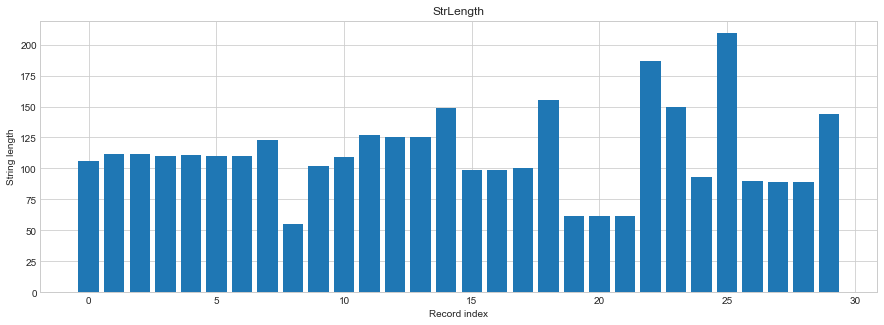

In [17]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

## Jaccard VS Edit distance variance

In [18]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [19]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

{(' ', 'o', 'f'), ('T', 'h', 'i'), ('a', 'n', ' '), ('m', 's', '!'), ('s', ' ', 'i'), ('m', 'm', 's'), ('i', 'g', 'r'), (' ', 'a', 'n'), ('i', 's', ' '), ('m', 's', ' '), ('n', 'd', ' '), ('f', ' ', 'b'), ('a', 'm', 'm'), (' ', 'e', 'x'), ('t', 'r', 'i'), ('a', 'm', 'p'), ('h', 'i', 's'), ('m', 'p', 'l'), ('n', ' ', 'e'), ('g', 'r', 'a'), ('b', 'i', 'g'), (' ', 'i', 's'), ('r', 'a', 'm'), ('e', ' ', 'o'), ('d', ' ', 't'), ('l', 'e', ' '), ('x', 'a', 'm'), ('a', 'n', 'd'), ('r', 'i', 'g'), ('s', ' ', 'a'), ('e', 'x', 'a'), (' ', 'b', 'i'), (' ', 't', 'r'), ('o', 'f', ' '), ('p', 'l', 'e')}
{('is', 'an', 'example'), ('This', 'is', 'an'), ('bigramms', 'and', 'trigramms'), ('of', 'bigramms', 'and'), ('an', 'example', 'of'), ('and', 'trigramms', '!'), ('example', 'of', 'bigramms')}
0.0
0.0


In [20]:
ed_matrix  = np.zeros((len(data),len(data)), dtype=np.int)
jc2_matrix = np.zeros((len(data),len(data)), dtype=np.float)
jc3_matrix = np.zeros((len(data),len(data)), dtype=np.float)
js2_matrix = np.zeros((len(data),len(data)), dtype=np.float)
js3_matrix = np.zeros((len(data),len(data)), dtype=np.float)

for i in range(0,len(data),1):
    for j in range(0,len(data),1):
        if i != j:
            ed_matrix[i][j]  = editdistance.eval(data[i],data[j])
            jc3_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=3)),set(nltk.ngrams(data[j], n=3)))
            js3_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=3)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=3)))
            jc2_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=2)),set(nltk.ngrams(data[j], n=2)))
            js2_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=2)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=2)))

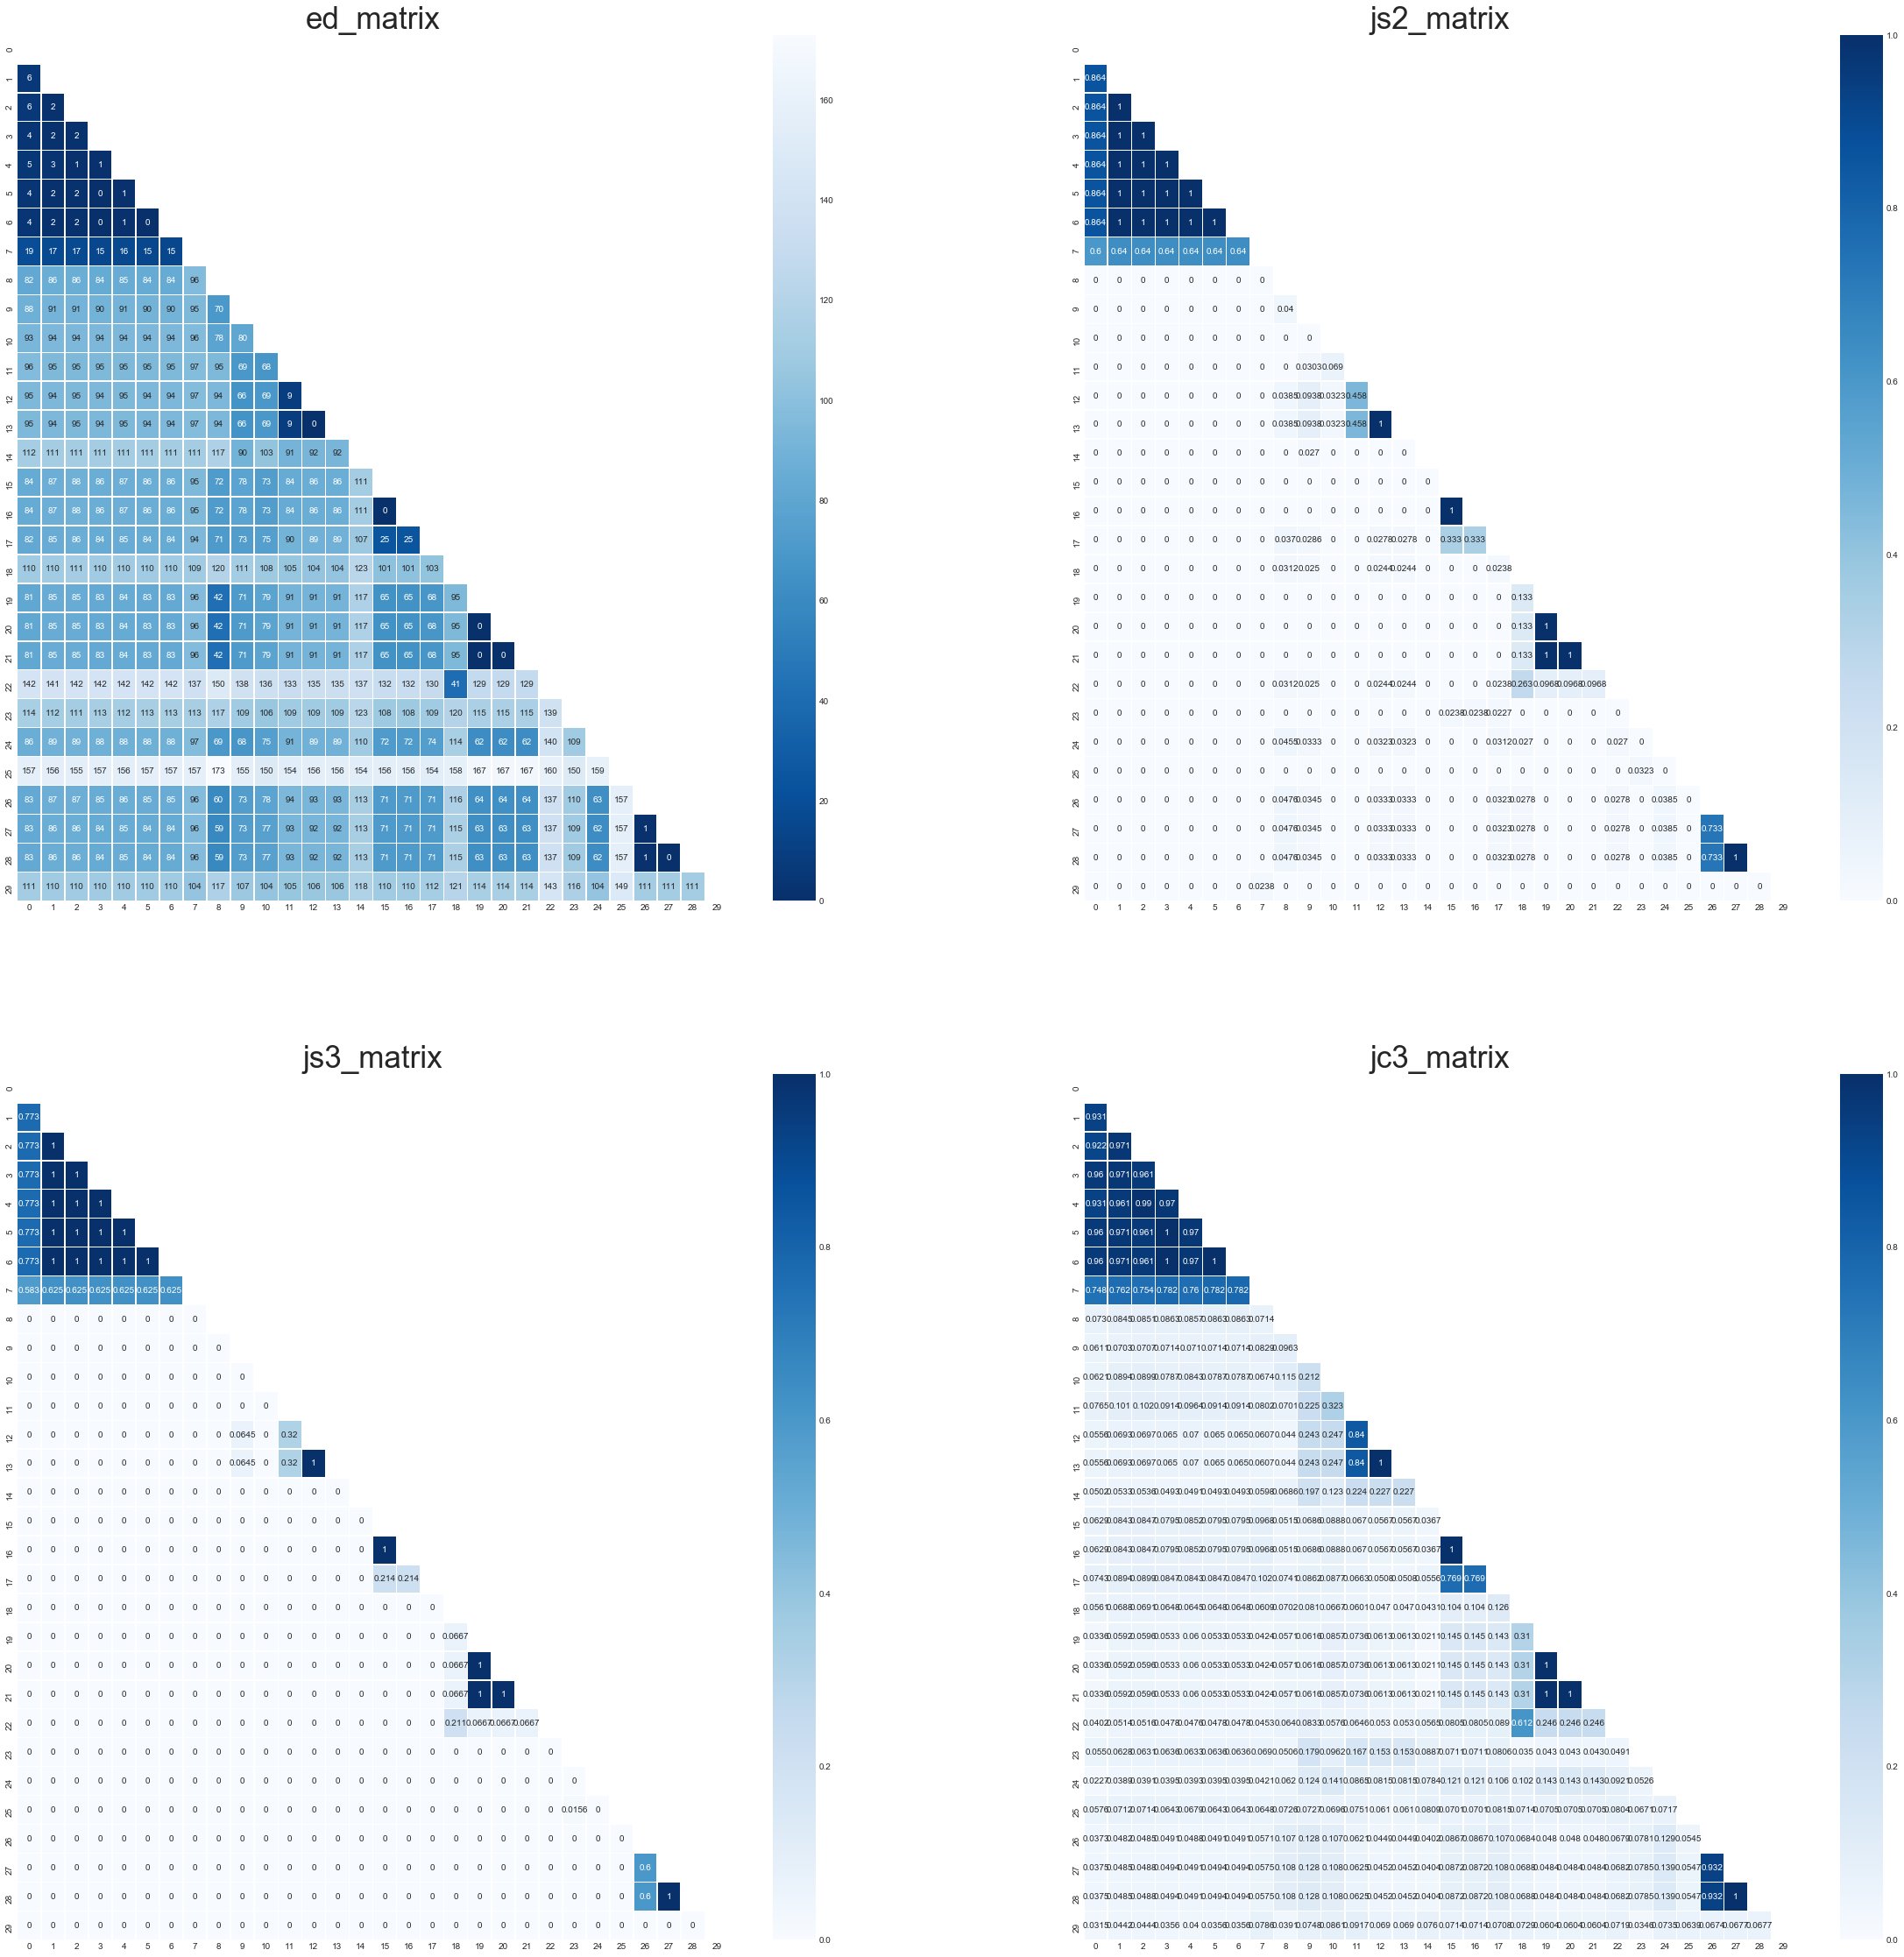

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,40))
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax1.set_title("ed_matrix",fontsize=35)
sns.heatmap(ed_matrix,  annot=True, linewidths=.5,cmap="Blues_r",fmt='.3g',mask=mask, ax=ax1)
ax2.set_title("js2_matrix",fontsize=35)
sns.heatmap(js2_matrix, annot=True, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax2)
ax3.set_title("js3_matrix",fontsize=35)
sns.heatmap(js3_matrix, annot=True, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax3)
ax4.set_title("jc3_matrix",fontsize=35)
sns.heatmap(jc3_matrix, annot=True, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax4)

### Edit Distance Heatmap

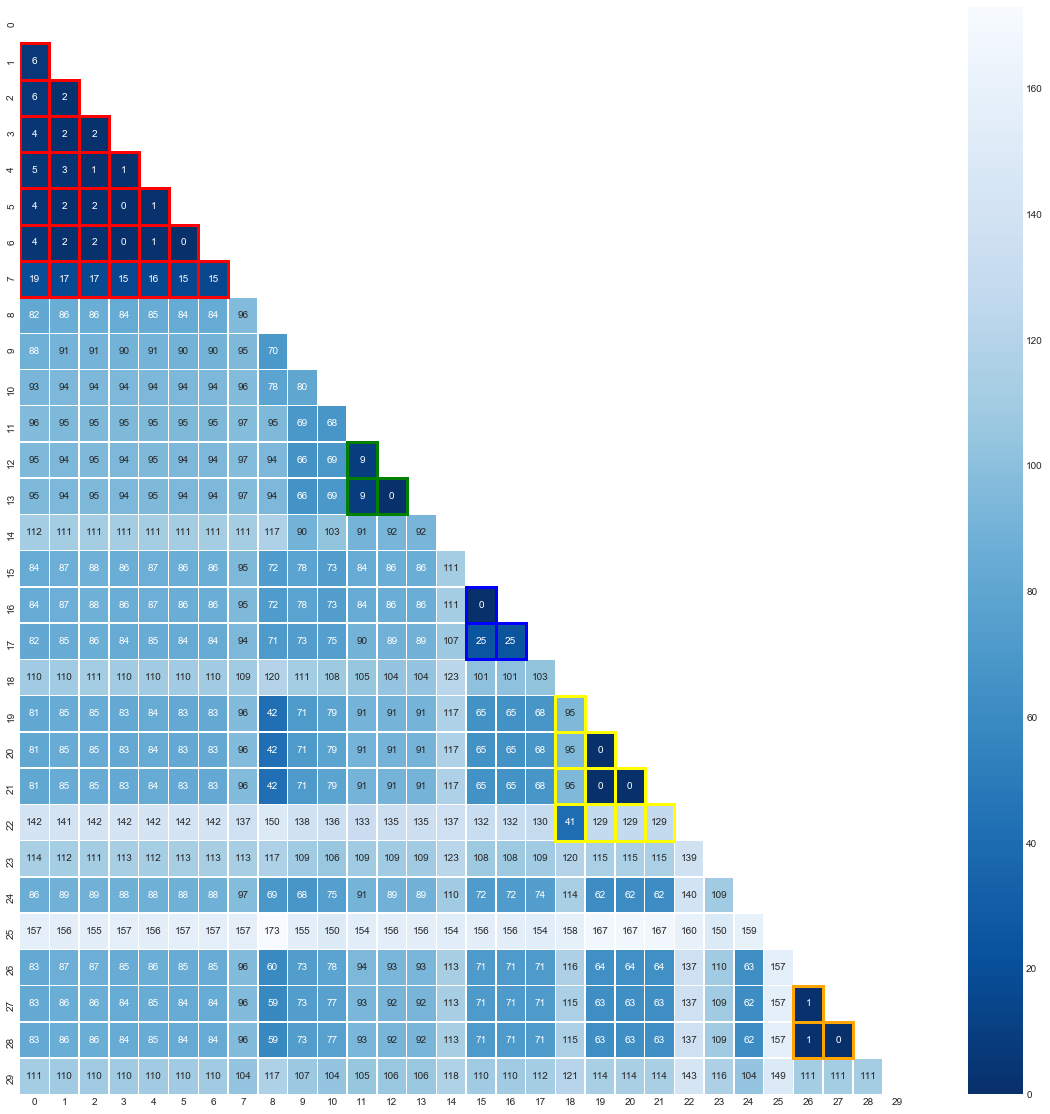

In [22]:
fif,ax = plt.subplots(1,figsize=(20,20))
colors = ['red','green','blue','yellow','orange']
c=0
for cl in clusters:
    for i  in range(0,len(cl)):
        for j in range(i+1,len(cl)):
            ax.add_patch(Rectangle(( cl[i],cl[j]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
    c+=1
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(ed_matrix, linewidth=0.5,annot=True,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
# plt.legend(legendclusters,colors)
# print(legendclusters)
plt.show()

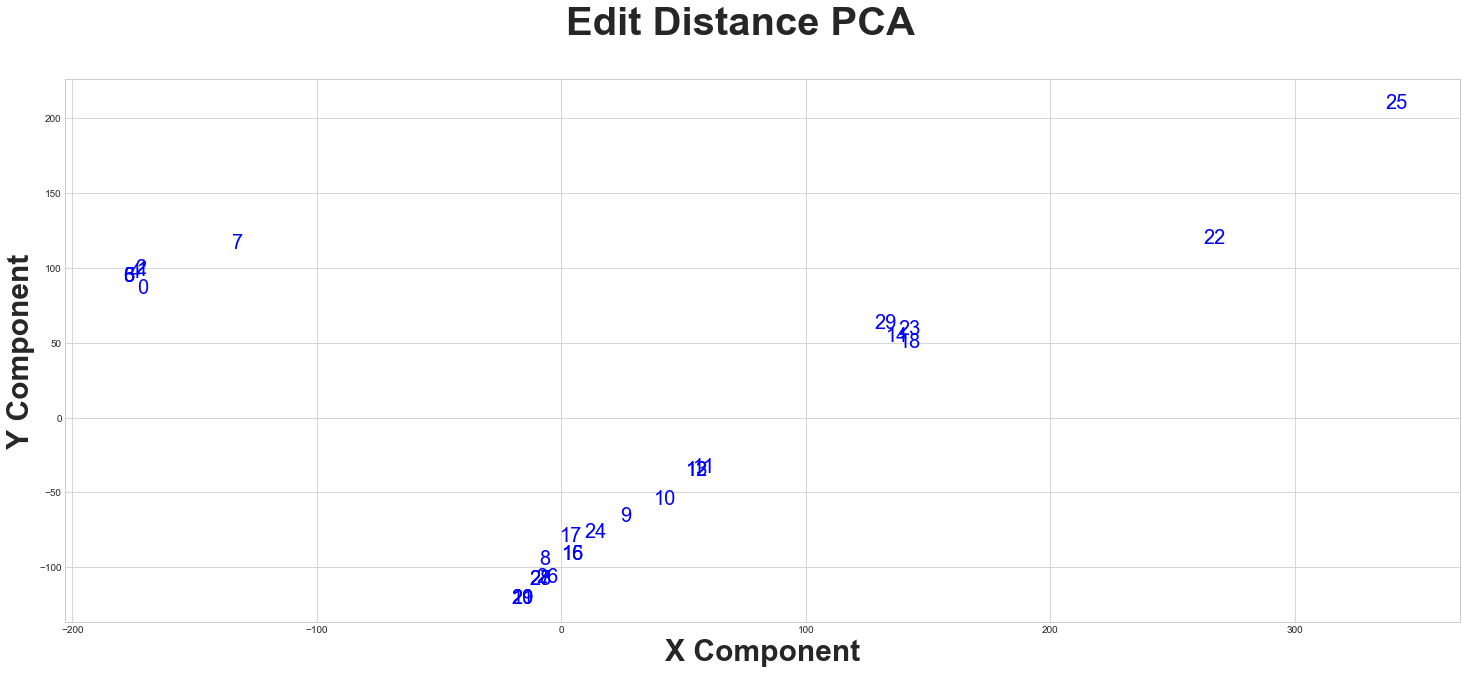

In [23]:
pcaComponents = PCA_SpaceVisualization(ed_matrix, 'Edit Distance PCA')

### Jaccard distance - using bgramms (2,3) Heatmap

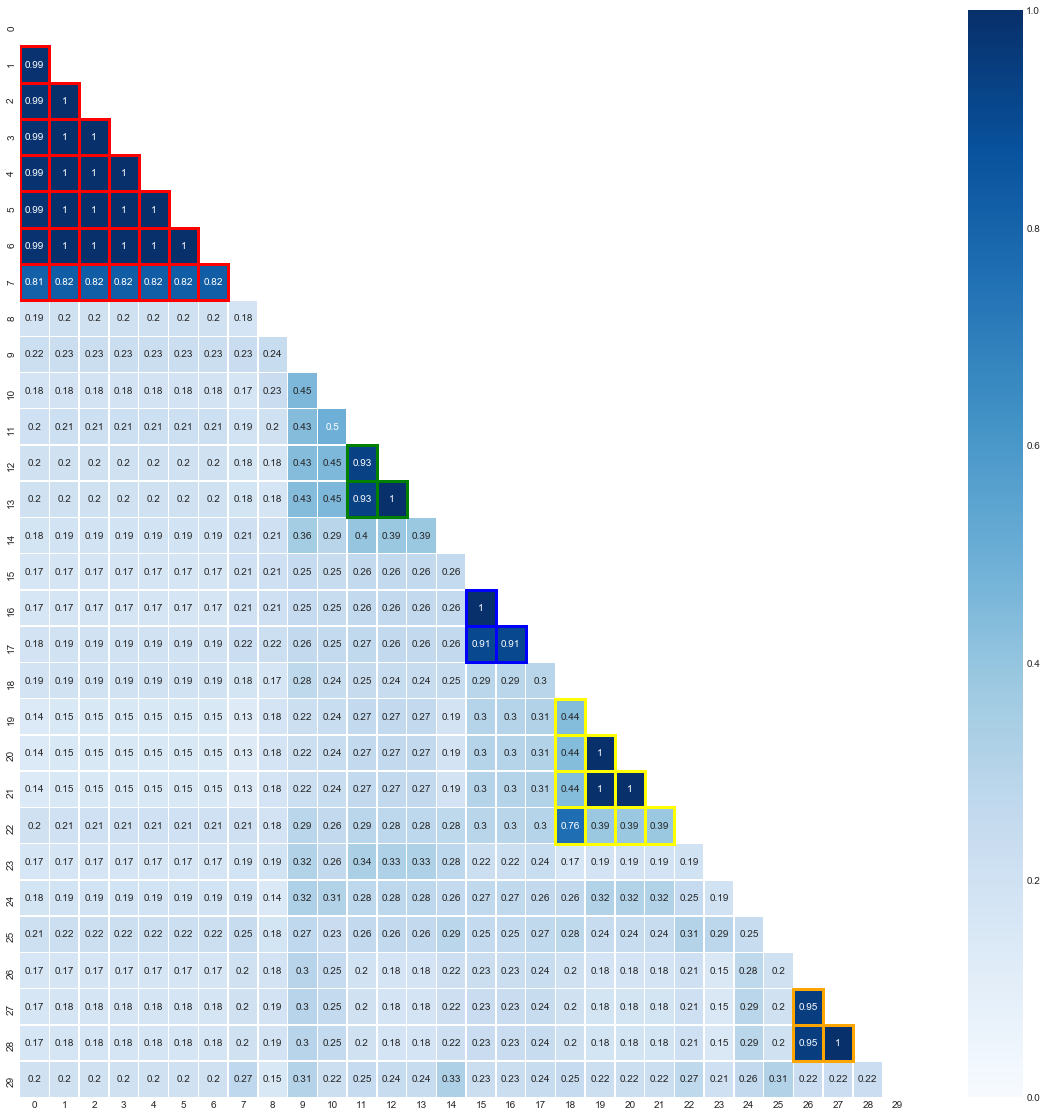

In [24]:
fif,ax = plt.subplots(1,figsize=(20,20))
colors = ['red','green','blue','yellow','orange']
c=0
for cl in clusters:
    for i  in range(0,len(cl)):
        for j in range(i+1,len(cl)):
            ax.add_patch(Rectangle((cl[i],cl[j]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
    c+=1
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(jc2_matrix, linewidth=0.5,annot=True,cmap="Blues",mask=mask,fmt='.2g',ax=ax)
plt.show()

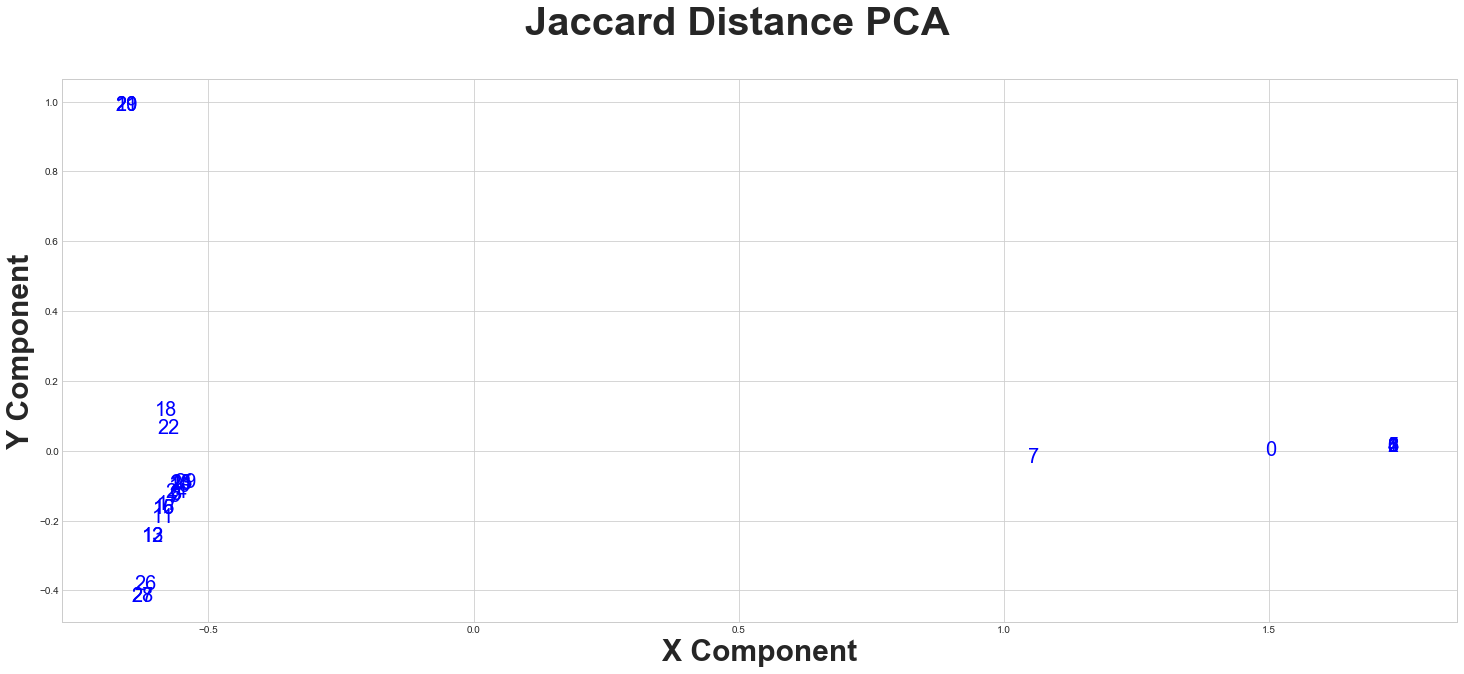

In [25]:
pcaComponents = PCA_SpaceVisualization(js2_matrix,  'Jaccard Distance PCA')

### Evaluation

In [26]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 13 16 21 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
16  ->  brown  d. f.  moura  h. & watt  d. a. actress: an action semantics directed compiler generator  nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0382 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 5 4]
 [2 5 4 3 1]
 [3 1 4 5 2]
 [5 1 3 4 2]
 [2 1 4 3 5]
 [2 1 4 3 5]
 [2 1 4 3 5]
 [2 1 4 5 3]
 [4 5 1 2 3]
 [4 5 1 2 3]
 [4 5 1 2 3]
 [4 5 2 1 3]
 [4 3 2 1 5]
 [4 3 2 1 5]
 [4 3 2 1 5]
 [5 4 2 1 3]
 [4 1 3 5 2]
 [5 4 3 1 2]
 [3 4 2 1 5]
 [3 5 2 4 1]
 [3 5 2 4 1]
 [3 5 2 4 1]
 [5 2 1 4 3]]

# Finished in 0.0358 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2 2]  ->  [0, 7, 8, 9, 14, 23, 26, 27, 28]
[0 0]  ->  [1, 2, 3, 4, 5, 6, 11, 12, 13, 19, 20, 21, 25]
[1 1]  ->  [10, 15, 16, 17, 18, 22, 24, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 1 5]
 [5 1 4]
 [5 1 4]
 [5 1 4]
 [5 1 4]
 [5 1 4]
 [5 1 4]
 [4 1 5]
 [1 2 3]
 [2 3 5]
 [2 5 4]
 [5 2 3]
 [5 2 3]
 [5

[0, 7, 8, 9, 14, 23, 26, 27, 28]
-- 3
-- 2
-- 2
-- 3
-- 2
-- 2
-- 2
-- 2
-- 2
-- 2
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 2
-- 3
-- 3
-- 3
-- 3
-- 2
-- 3
-- 3
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
[1, 2, 3, 4, 5, 6, 11, 12, 13, 19, 20, 21, 25]
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 2
-- 2
-- 2
-- 2
-- 3
-- 2
-- 2
-- 2
-- 2
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
[10, 15, 16, 17, 18, 22, 24, 29]
-- 2
-- 2
-- 2
-- 2
-- 2
-- 2
-- 3
-- 3
-- 3
-- 3
-- 3
-- 3
-- 2
-- 3
-- 3
-- 3
-- 3
-- 2
-- 3
-- 3
-- 3
-- 2
-- 3
-- 3
-- 2
-- 3
-- 2
-- 2

- Similarity mapping in a matrix
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0

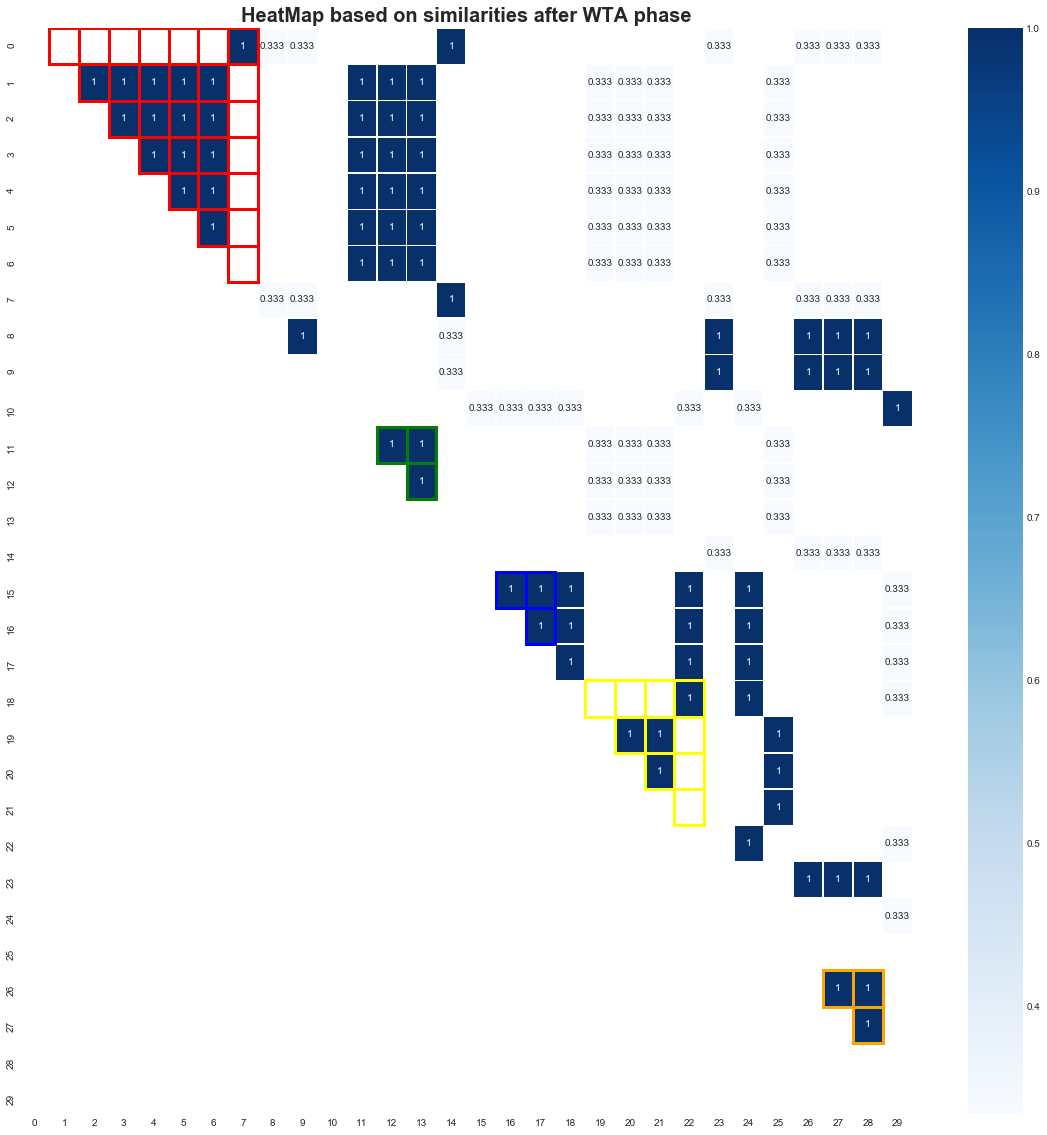

Wall time: 2.1 s


In [55]:
%%time
model = RankedWTAHash(
    max_numberOf_clusters= 30,
    max_editDistance= 0.3,
    windowSize= 3,
    similarityThreshold= 0.799,
    metric='kendal',
    similarityVectors='ranked',
    number_of_permutations = 2,
    distanceMetric= 'jaccard',
    distanceMetricEmbedding = 'jaccard',
    ngramms= 3,
    jaccard_withchars = True
)
model = model.fit(data)
evaluate_cora(model.mapping_matrix,true_matrix, False)
similarityProbsHeatMap(model.similarityProb_matrix,clusters,'HeatMap based on similarities after WTA phase')


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 4 13 16 21 28]
4  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o.  inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
16  ->  brown  d. f.  moura  h. & watt  d. a. actress: an action semantics directed compiler generator  nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0313 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 1 1 1 1]
 [2 1 2 2 2]
 [1 1 1 1 1]
 [2 1 2 2 2]
 [2 1 2 2 2]
 [2 1 2 2 2]
 [1 1 1 1 1]
 [2 2 1 2 2]
 [2 2 1 2 2]
 [2 2 1 2 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [2 2 2 2 1]
 [2 2 2 2 1]
 [2 2 2 2 1]
 [1 1 1 1 1]]

# Finished in 0.0605 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1 0 0 0 1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0 0 0 0 0]  ->  [8, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29]
[0 0 1 1 0]  ->  [9, 11, 12, 13]
[0 1 0 0 0]  ->  [26, 27, 28]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29]
[9, 11, 12, 13]
[26, 27, 28]

- Similarity mapping in a matrix
[[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

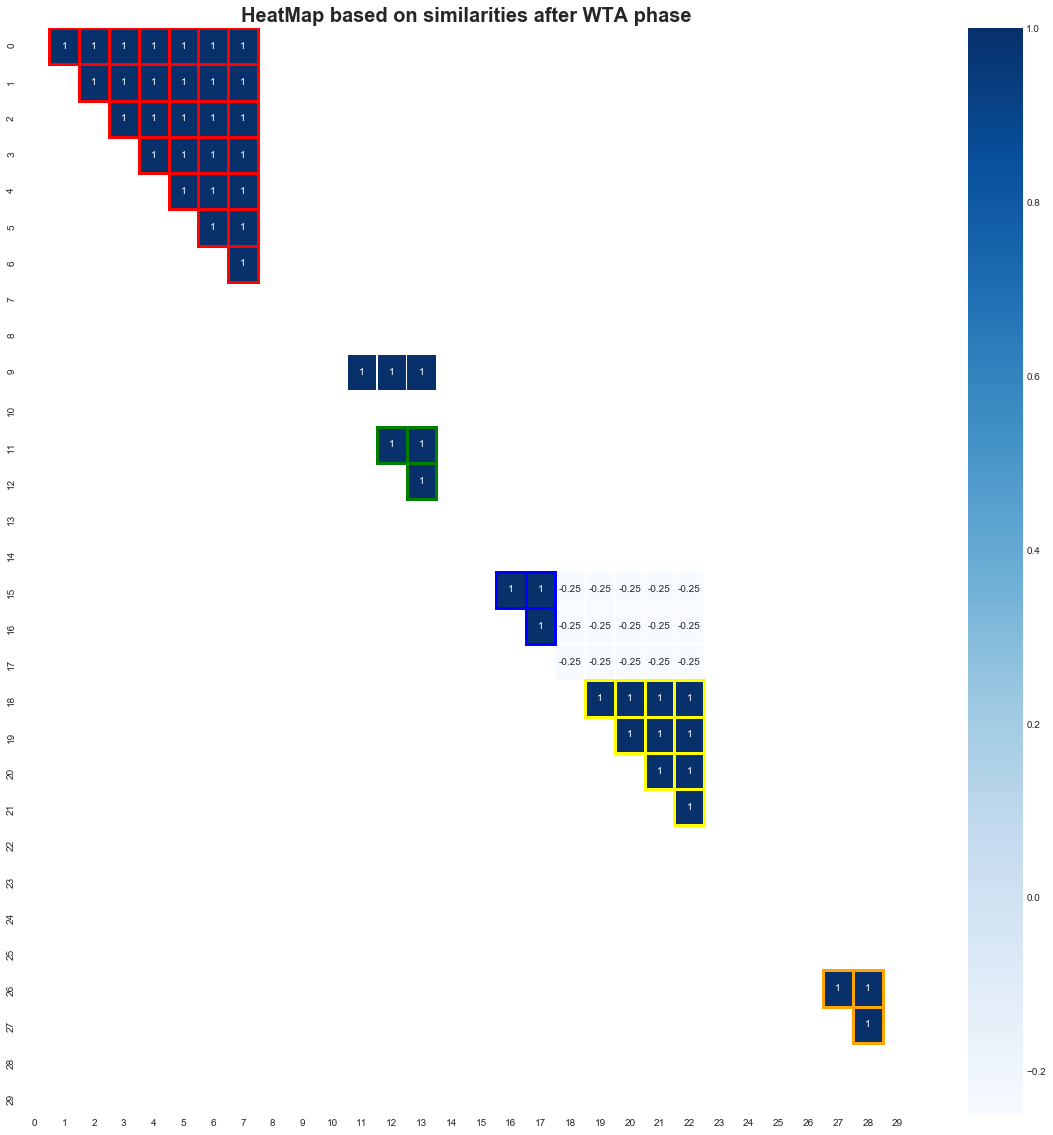

Wall time: 1.79 s


In [28]:
%%time
model = RankedWTAHash(
    max_numberOf_clusters= 30,
    max_editDistance= 0.6,
    windowSize= 5,
    similarityThreshold= 0.799,
    metric='kendal',
    similarityVectors='ranked',
    number_of_permutations = 5,
    distanceMetric= 'jaccard',
    distanceMetricEmbedding = 'l_inf',
    ngramms= 3,
    jaccard_withchars = False
)
model = model.fit(data)
evaluate_cora(model.mapping_matrix,true_matrix, False)
similarityProbsHeatMap(model.similarityProb_matrix,clusters,'HeatMap based on similarities after WTA phase')

## Performance details

### Embeddings

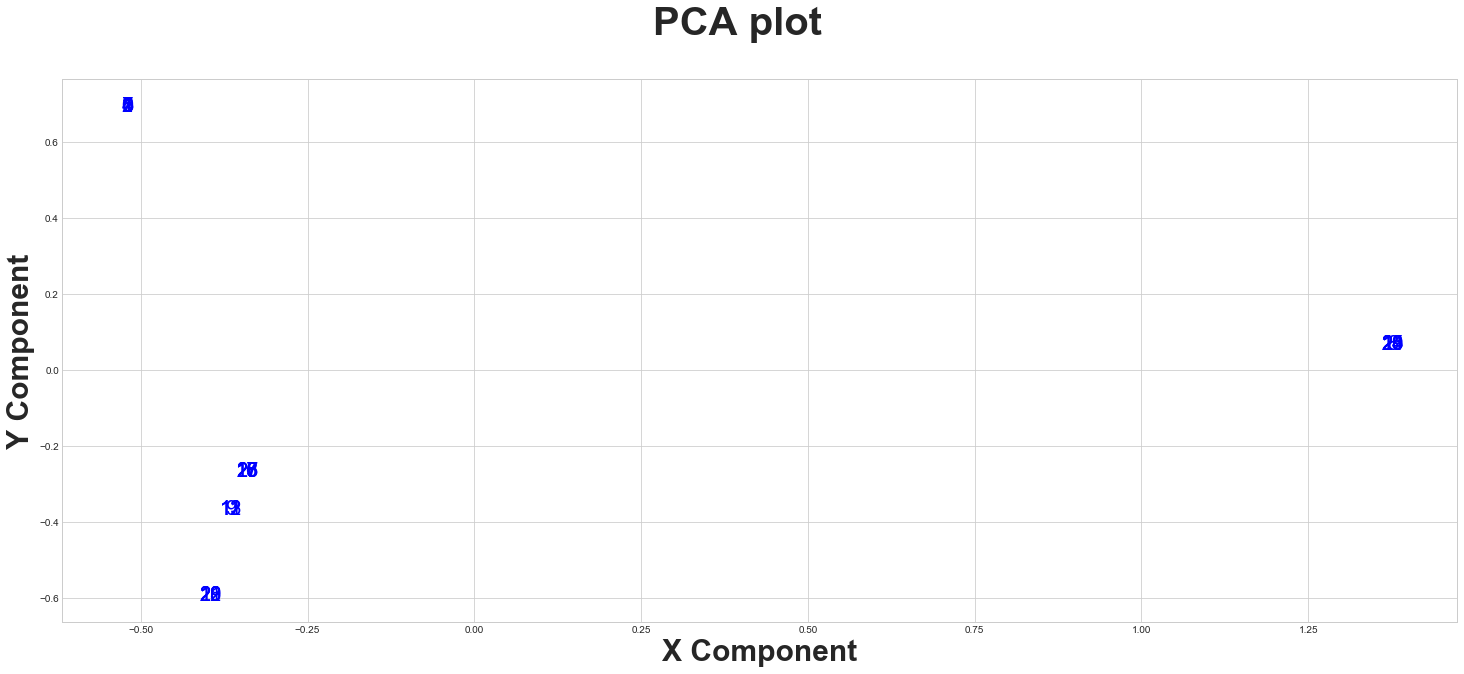

In [29]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

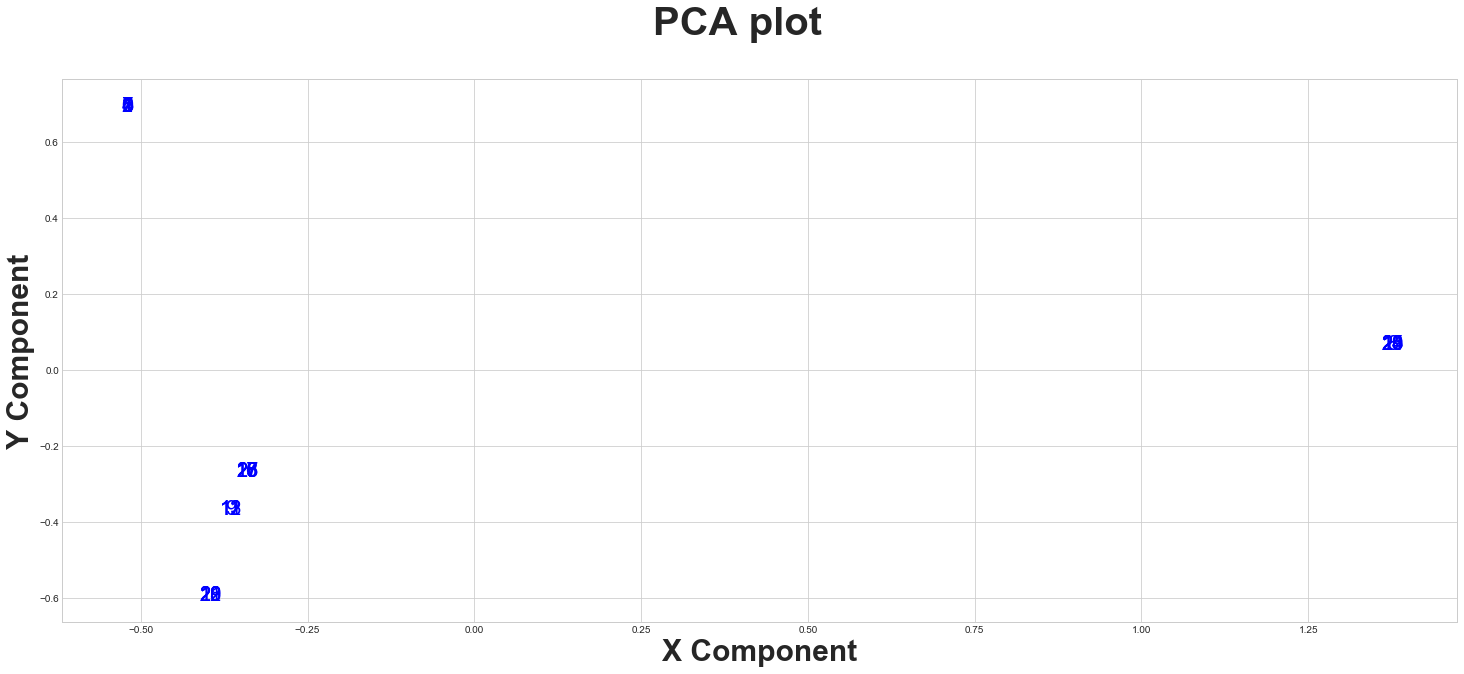

In [30]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

### Grid Search

In [31]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.6,0.7,0.8]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']
distanceMetric= ['edit']
distanceMetricEmbedding = ['edit','euclidean']
number_of_permutations = [1,3,5,7]


# results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

In [32]:
results.sort_values(by=['Accuracy'],ascending=False)

NameError: name 'results' is not defined

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)